In [1]:
data = open('HP1.txt','r', encoding="utf8").read();
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(data_size,", ",vocab_size)

char_to_ix = {ch:i for i, ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}
print(char_to_ix)
print(ix_to_char)

def encode(idx,num_entry):
    ret = np.zeros(num_entry)
    ret[idx] = 1
    return ret;

def encode_array(array,num_entry):
    xs = np.zeros((len(array),num_entry))
    for i in range(len(array)):
        xs[i][array[i]] = 1; 
    return xs;

431677 ,  79
{'E': 0, 'Y': 1, 'o': 2, 'K': 3, '6': 4, 'Q': 5, 'v': 6, 'N': 7, 'c': 8, '7': 9, 'u': 10, 'm': 11, '.': 12, '9': 13, '(': 14, '\\': 15, 'b': 16, 'n': 17, 't': 18, 'W': 19, 'q': 20, 'l': 21, '\n': 22, '2': 23, '"': 24, 'V': 25, '~': 26, 'y': 27, 'f': 28, 'A': 29, 'L': 30, 'p': 31, 'R': 32, '!': 33, 'x': 34, 'B': 35, '1': 36, 'r': 37, 'H': 38, 'j': 39, '3': 40, '*': 41, ' ': 42, 'e': 43, 'I': 44, 'G': 45, 'P': 46, ',': 47, ';': 48, 'U': 49, 'w': 50, ':': 51, 'C': 52, ')': 53, 'S': 54, 'd': 55, 'g': 56, 'J': 57, '4': 58, 's': 59, '5': 60, '?': 61, '\t': 62, "'": 63, 'X': 64, 'Z': 65, 'T': 66, 'i': 67, 'F': 68, 'M': 69, '-': 70, 'h': 71, 'D': 72, 'a': 73, '0': 74, 'z': 75, 'O': 76, '8': 77, 'k': 78}
{0: 'E', 1: 'Y', 2: 'o', 3: 'K', 4: '6', 5: 'Q', 6: 'v', 7: 'N', 8: 'c', 9: '7', 10: 'u', 11: 'm', 12: '.', 13: '9', 14: '(', 15: '\\', 16: 'b', 17: 'n', 18: 't', 19: 'W', 20: 'q', 21: 'l', 22: '\n', 23: '2', 24: '"', 25: 'V', 26: '~', 27: 'y', 28: 'f', 29: 'A', 30: 'L', 31: 'p', 3

In [36]:
import numpy as np
import copy

# Helper functions
def softmax(array):
    return np.exp(array)/ np.sum(np.exp(array)) # return an array

def sigmoid(x):
    return (1/(1+np.exp(-x)))

def sigmoid_deriv(y):
    return (y*(1-y))

def tanh(x):
    return np.tanh(x)

def tanh_deriv(y):
    return 1 - pow(np.tanh(y),2)

# RNN
class myRNN:
    
    def __init__ (self, lenIn, lenOut, lenRec, sizeHidden, inputs_encoded, targets, learningRate,dropout_threshold):
        
        # Hyper parameters
        self.lenIn          = lenIn
        self.lenOut         = lenOut
        self.lenRec         = lenRec
        self.sizeHidden     = sizeHidden
        self.learningRate   = learningRate
        self.dropout_threshold = dropout_threshold
        
        # input & expected output
        self.inputs_encoded = inputs_encoded;
        self.targets = targets;
        
        # parameters for inference
        self.x  = np.zeros(lenIn)  
        self.y  = np.zeros(lenOut)
        self.h  = np.zeros(sizeHidden)
        self.c  = np.zeros(sizeHidden)
        
        self.W  = np.zeros((lenOut,sizeHidden)) # for the last fully connected layer
        self.GW = np.zeros((lenOut,sizeHidden)) # Gradient, for W-update using RMSprop
        self.b  = np.zeros(lenOut)
        self.Gb = np.zeros(lenOut)
        
        # for training phase 
        self.xs = np.zeros((lenRec,lenIn))
        self.ys = np.zeros((lenRec,lenOut))
        self.cs = np.zeros((lenRec,sizeHidden))
        self.hs = np.zeros((lenRec,sizeHidden))
        
        # for training phase bookkeeping
        self.fg = np.zeros((lenRec,sizeHidden)) # forget gate
        self.ig = np.zeros((lenRec,sizeHidden)) # input  gate
        self.og = np.zeros((lenRec,sizeHidden)) # output gate
        self.mc = np.zeros((lenRec,sizeHidden)) # memory cell state (candidate)
        
        # LSTM class
        self.LSTM = LSTM(sizeHidden+lenIn,sizeHidden,lenRec,learningRate)
        
        # Dropout vector
        self.dvo = np.zeros((lenRec,sizeHidden));
        
        ''' end of myRNN.__init__ '''
       
    ''' This is used when mini-batch is used '''            
    def update_inputs_targets(self, inputs_encoded, targets):
        self.inputs_encoded  = inputs_encoded
        self.targets         = targets
    
    def fwd_pass(self): 
                
        prev_h = np.zeros_like(self.hs[0])
        for t in range(0,self.lenRec):
            for i in range(self.dvo.shape[1]):
                rand = np.random.random()
                if(rand > self.dropout_threshold):
                    self.dvo[t][i] = 1;
                else:
                    self.dvo[t][i] = 0;
            # update input
            self.x    = self.inputs_encoded[t]
            self.xs[t]= self.inputs_encoded[t]
            
            self.LSTM.hx = np.hstack((prev_h, self.x));
            self.LSTM.dvo = self.dvo[t];
            
            c, h, f, i, m, o = self.LSTM.fwd_pass()
            # bookkeeping
            self.cs[t] = c
            self.hs[t] = h
            self.fg[t] = f
            self.ig[t] = i
            self.mc[t] = m
            self.og[t] = o
            
            # output layer - fully connected layer
            self.ys[t] = np.dot(self.W,self.hs[t]) + self.b
            prev_h = self.hs[t]
            
        return;              
    
    def bwd_pass(self):        

        avg_loss = 0; # using cross entropy average
        c2next_grad  = np.zeros(self.sizeHidden)
        h2next_grad  = np.zeros(self.sizeHidden)
        
        # output bp
        W_grad   = np.zeros((self.lenOut,self.sizeHidden))
        b_grad  = np.zeros(self.lenOut)
        
        # LSTM internal bp
        hxf_grad   = np.zeros((self.sizeHidden,self.LSTM.lenIn));
        hxi_grad   = np.zeros((self.sizeHidden,self.LSTM.lenIn));
        hxm_grad   = np.zeros((self.sizeHidden,self.LSTM.lenIn));
        hxo_grad   = np.zeros((self.sizeHidden,self.LSTM.lenIn));
    
        fb_grad   = np.zeros(self.sizeHidden)
        ib_grad   = np.zeros(self.sizeHidden)
        mb_grad   = np.zeros(self.sizeHidden)
        ob_grad   = np.zeros(self.sizeHidden)
                   
        # propagates through time and layers

        for t in reversed(range(0,self.lenRec)):
            
            prob = softmax(self.ys[t]) # prevent zero
            prob_fix  = prob + 1e-9
#            if(prob[self.targets[t]] == 0):
#                for ii in range(10000):
#                    print("ERR!",self.ys[t][self.targets[t]]," ",np.sum(self.ys[t]))
                
            # cross entropy
            err       = np.log(prob_fix[int(self.targets[t])])
            avg_loss += err
     
            dy = copy.deepcopy(prob)
            dy[int(self.targets[t])] -= 1
            
            W_grad += np.dot((np.atleast_2d(dy)).T,np.atleast_2d(self.hs[t]))
            b_grad += dy
            
            dh = np.dot(self.W.T,dy) + h2next_grad
            
            x_grad  = np.zeros(self.lenIn)
            
            if(t > 0):
                prev_h = self.hs[t-1]
                prev_c = self.cs[t-1]
            else:
                prev_h = np.zeros_like(self.hs[0])
                prev_c = np.zeros_like(self.cs[0])
                
            self.LSTM.hx = np.hstack((prev_h,self.xs[t]));
            self.LSTM.c = self.cs[t];
            
            self.LSTM.dvo = self.dvo[t];
            
            dhxf,dhxi,dhxm,dhxo, dbf,dbi,dbm,dbo, c2next_grad,h2next_grad,x_grad = \
            self.LSTM.bwd_pass( dh, prev_c ,self.fg[t],self.ig[t],self.mc[t],self.og[t],\
                                 c2next_grad);
            
            for ii in range(dhxo.shape[0]):
                dhxo[ii] *= self.dvo[t][ii];   
                
            hxf_grad +=  dhxf;
            hxi_grad +=  dhxi;  
            hxm_grad +=  dhxm;  
            hxo_grad +=  dhxo;   
            
            fb_grad +=  dbf;
            ib_grad +=  dbi;
            mb_grad +=  dbm;
            ob_grad +=  np.multiply(dbo,self.dvo[t]);   

        
        # update using RMSprop
        self.LSTM.update(hxf_grad/self.lenRec, hxi_grad/self.lenRec, \
                           hxm_grad/self.lenRec, hxo_grad/self.lenRec, \
                           fb_grad/self.lenRec, ib_grad/self.lenRec, \
                           mb_grad/self.lenRec, ob_grad/self.lenRec);

        
        self.update(W_grad/self.lenRec,b_grad/self.lenRec);
        return avg_loss/self.lenRec;
            
          
            
    def update(self, W_grad, b_grad):
        self.GW = 0.9*self.GW + 0.1*W_grad**2;
        self.W -= self.learningRate/np.sqrt(self.GW + 1e-8) * W_grad;
        self.Gb = 0.9*self.Gb + 0.1*b_grad**2;
        self.b -= self.learningRate/np.sqrt(self.Gb + 1e-8) * b_grad;

    def inference(self,x):
        # update input
        self.x = x
        self.LSTM.hx = np.hstack((self.h,self.x))
        c, h, f, i, m, o = self.LSTM.fwd_pass()
        self.c = c
        self.h = h

        # output layer - may replace with softmax instead
        self.y = np.dot(self.W,self.h) + self.b
        p   = softmax(self.y)     
        return np.random.choice(range(self.lenOut), p=p.ravel())
  


In [37]:
class LSTM:
    
    def __init__ (self,lenIn,sizeHidden,lenRec,learningRate):
        self.lenIn        = lenIn
        self.sizeHidden   = sizeHidden
        self.lenRec       = lenRec
        self.learningRate = learningRate
        
        # hx == x is x and h horizontally stacked together
        self.hx = np.zeros(lenIn)
        self.c = np.zeros(sizeHidden)
        self.h = np.zeros(sizeHidden)
        
        # Weight matrices
        self.fW = np.random.random((sizeHidden,lenIn));
        self.iW = np.random.random((sizeHidden,lenIn));
        self.mW = np.random.random((sizeHidden,lenIn)); # cell state
        self.oW = np.random.random((sizeHidden,lenIn));
                             
        # biases
        self.fb = np.zeros(sizeHidden);
        self.ib = np.zeros(sizeHidden); 
        self.mb = np.zeros(sizeHidden); 
        self.ob = np.zeros(sizeHidden); 
               
        # for RMSprop only
        self.GfW = np.random.random((sizeHidden,lenIn));
        self.GiW = np.random.random((sizeHidden,lenIn));
        self.GmW = np.random.random((sizeHidden,lenIn)); 
        self.GoW = np.random.random((sizeHidden,lenIn));
                             
        self.Gfb = np.zeros(sizeHidden);
        self.Gib = np.zeros(sizeHidden); 
        self.Gmb = np.zeros(sizeHidden);
        self.Gob = np.zeros(sizeHidden); 
        
        # for dropout
        self.dvo = np.zeros(sizeHidden); 
        ''' end of LSTM.__init__ '''
        
    def fwd_pass(self):
        f       = sigmoid(np.dot(self.fW, self.hx) + self.fb)
        i       = sigmoid(np.dot(self.iW, self.hx) + self.ib)
        m       = tanh(   np.dot(self.mW, self.hx) + self.mb)        
        o       = sigmoid(np.dot(self.oW, self.hx) + self.ob)
        o       = np.multiply(o,self.dvo); # dropout
        self.c *= f
        self.c += i * m
        self.h  = o * tanh(self.c)
        
        return self.c, self.h, f, i, m, o;
    
    def bwd_pass(self, dh, prev_c, f, i, m, o, c_g):
        
        dh = np.clip(dh, -6, 6);       
        # h = o*tanh(c)
        do  = tanh(self.c) * dh
        do  = sigmoid_deriv(o)*do
        #do  = np.multiply(do,self.dvo)
        dhxo = np.dot((np.atleast_2d(do)).T,np.atleast_2d(self.hx)) 
        
        # h = o*tanh(c) - add c_g (c_grad in next timestep, account for the branch here)
        dcs = dh * o * tanh_deriv(self.c) + c_g
        dcs = np.clip(dcs, -6, 6); 
        
        # c = c_prev * f + m * i
        dm = i * dcs
        dm = tanh_deriv(m) * dm
        dhxm = np.dot((np.atleast_2d(dm)).T,np.atleast_2d(self.hx)) 
        
        # c = c_prev * f + m * i
        di  = m * dcs
        di  = sigmoid_deriv(i) * di
        dhxi = np.dot((np.atleast_2d(di)).T,np.atleast_2d(self.hx)) 
        
        # c = c_prev * f + m * i
        df = prev_c * dcs
        df = sigmoid_deriv(f) * df
        dhxf = np.dot((np.atleast_2d(df)).T,np.atleast_2d(self.hx)) 
        
        # c = c_prev * f + m * i
        c_grad  = dcs * f
        hx_grad = np.dot(self.fW.T, df) + np.dot(self.iW.T, di) +\
                          np.dot(self.oW.T, do) + np.dot(self.mW.T, dm)
        
        
        return dhxf,dhxi,dhxm,dhxo,df,di,dm,do,c_grad,hx_grad[:self.sizeHidden],hx_grad[self.sizeHidden:];
    
    def update(self, f_grad, i_grad, m_grad, o_grad, fb_grad, ib_grad, mb_grad, ob_grad):

        self.GfW = 0.9*self.GfW + 0.1*f_grad**2
        self.GiW = 0.9*self.GiW + 0.1*i_grad**2
        self.GmW = 0.9*self.GmW + 0.1*m_grad**2
        self.GoW = 0.9*self.GoW + 0.1*o_grad**2
        
        self.Gfb = 0.9*self.Gfb + 0.1*fb_grad**2
        self.Gib = 0.9*self.Gib + 0.1*ib_grad**2
        self.Gmb = 0.9*self.Gmb + 0.1*mb_grad**2
        self.Gob = 0.9*self.Gob + 0.1*ob_grad**2
        
        self.fW -= self.learningRate/np.sqrt(self.GfW + 1e-8) * f_grad
        self.iW -= self.learningRate/np.sqrt(self.GiW + 1e-8) * i_grad
        self.mW -= self.learningRate/np.sqrt(self.GmW + 1e-8) * m_grad
        self.oW -= self.learningRate/np.sqrt(self.GoW + 1e-8) * o_grad
        
        self.fb -= self.learningRate/np.sqrt(self.Gfb + 1e-8) * fb_grad
        self.ib -= self.learningRate/np.sqrt(self.Gib + 1e-8) * ib_grad
        self.mb -= self.learningRate/np.sqrt(self.Gmb + 1e-8) * mb_grad
        self.ob -= self.learningRate/np.sqrt(self.Gob + 1e-8) * ob_grad
        

In [48]:
## Try a reduced/increased drop out probability


seq_length,position = 75,0
inputs = [char_to_ix[ch] for ch in data[position:position+seq_length]]
print(data[position:position+seq_length])
print("inputs",inputs)

targets = [char_to_ix[ch] for ch in data[position+1:position+seq_length+1]] 
print(data[position+1:position+seq_length+1])
print("targets",targets)

n,position = 0,0;
epoch = 20*1000;
lenIn, lenOut, lenRec = vocab_size,vocab_size, seq_length
sizeHidden, numHiddenLayer = 64,1;
learningRate = 0.1;
dropout_threshold = 0.1;

R = myRNN(lenIn, lenOut, lenRec, sizeHidden, encode_array(inputs,vocab_size),targets, learningRate,dropout_threshold)

# training

err_curve = [];

while n<epoch:
    R.learningRate = 0.05+0.05*np.exp(-n/(100*100))
    R.dropout_threshold = 0.7-0.6*np.exp(-n/(100*100))
    
    if(position+seq_length+1 >= len(data) or n == 0):
        print("!!!!",len(data))
        position = 0;
        
    inputs  = [char_to_ix[ch] for ch in data[position:position+seq_length]]
    targets = [char_to_ix[ch] for ch in data[position+1:position+seq_length+1]] 

    R.update_inputs_targets(encode_array(inputs,vocab_size),targets)
    R.fwd_pass();
    
    err = R.bwd_pass();
    err_curve.append(err);
    
    if(n%500 == 0):
        
        print(n,"err:",err," R.learningRate:", R.learningRate,"dropout_threshold:",R.dropout_threshold)
        seed = encode(n % vocab_size,vocab_size)
        print(ix_to_char[n % vocab_size])
        result = [];
        R.h  = np.zeros(sizeHidden)
        R.c  = np.zeros(sizeHidden)
        print("<Inference>:")
        for i in range(40):
            ret = R.inference(seed)
            result.append(ret)
            seed = encode(ret,vocab_size)
        decode = ''.join([ix_to_char[ch] for ch in result] )
        print(decode)
        
        print("\n<Predict>:")
        inputs  = [char_to_ix[ch] for ch in data[position:position+seq_length]]
        targets = [char_to_ix[ch] for ch in data[position+1:position+seq_length+1]] 
        result = [];
        compare = [];
        for i in range(40):
            ret = R.inference(encode(inputs[i],vocab_size))
            result.append(ret)
            compare.append(targets[i])
        in_decode = ''.join([ix_to_char[ch] for ch in result] )
        cm_decode = ''.join([ix_to_char[ch] for ch in compare] )
        print("<Predict>:",in_decode)
        print("<Targets>:",cm_decode)
    position += seq_length;
    n += 1;

Harry Potter and the Sorcerer's Stone
CHAPTER ONE
THE BOY WHO LIVED
Mr. and
inputs [38, 73, 37, 37, 27, 42, 46, 2, 18, 18, 43, 37, 42, 73, 17, 55, 42, 18, 71, 43, 42, 54, 2, 37, 8, 43, 37, 43, 37, 63, 59, 42, 54, 18, 2, 17, 43, 22, 52, 38, 29, 46, 66, 0, 32, 42, 76, 7, 0, 22, 66, 38, 0, 42, 35, 76, 1, 42, 19, 38, 76, 42, 30, 44, 25, 0, 72, 22, 69, 37, 12, 42, 73, 17, 55]
arry Potter and the Sorcerer's Stone
CHAPTER ONE
THE BOY WHO LIVED
Mr. and 
targets [73, 37, 37, 27, 42, 46, 2, 18, 18, 43, 37, 42, 73, 17, 55, 42, 18, 71, 43, 42, 54, 2, 37, 8, 43, 37, 43, 37, 63, 59, 42, 54, 18, 2, 17, 43, 22, 52, 38, 29, 46, 66, 0, 32, 42, 76, 7, 0, 22, 66, 38, 0, 42, 35, 76, 1, 42, 19, 38, 76, 42, 30, 44, 25, 0, 72, 22, 69, 37, 12, 42, 73, 17, 55, 42]
!!!! 431677
0 err: -4.36944777346702  R.learningRate: 0.1 dropout_threshold: 0.09999999999999998
E
<Inference>:
nHdSP O
E e h oSEdOtPre
TPPP
HEOPdetOdtP

<Predict>:
<Predict>: oTOSo 
EdEeenoeEtPdnTHPtHPMWteoO

CPTE
n
<Targets>: arry Potter and the Sor

KeyboardInterrupt: 

In [234]:
k = [1,2,3,4]
u = k[3:]
print(u)

[4]


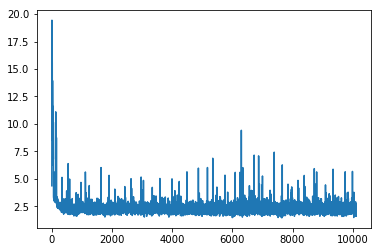

In [49]:
import matplotlib.pyplot as plt
plt.plot(-np.array(err_curve));
plt.show()